In [1]:
import os
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torchvision 
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models
from PIL import Image
from skimage import io, transform
from sklearn.tree import DecisionTreeClassifier
from helper_data import get_dataloaders_celeba


In [3]:
dim = [64,2]
transform = transforms.Compose([transforms.ToTensor(),                                
                                transforms.ColorJitter(brightness=.3, hue=.1),
                                transforms.Normalize(mean=[0.5], std=[0.5]),
                                transforms.RandomRotation((-30,30)),
                                transforms.Resize(size=[218//dim[1], 178//dim[1]]),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.CenterCrop((dim[0],dim[0]))])
    
x,y,z = get_dataloaders_celeba(128, train_transforms=transform, test_transforms=transform, target_type=['landmarks'])

Files already downloaded and verified


/home/michal/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow wit

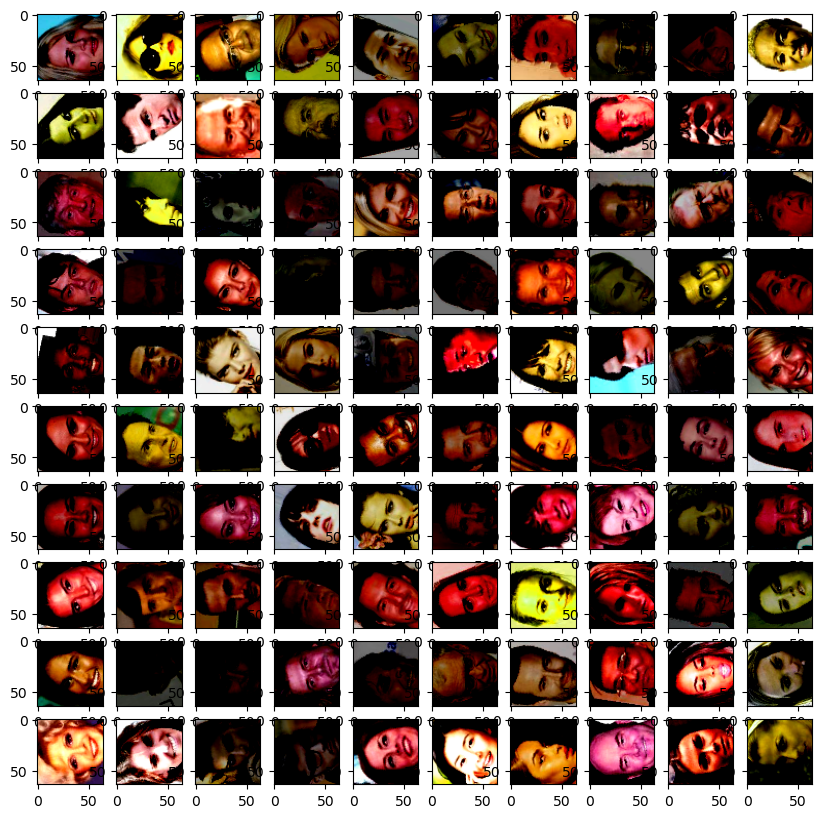

In [5]:
fg, ax = plt.subplots(10,10,figsize=(10,10))
im = next(iter(x))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(im[0][i+10*j].numpy().T)

In [4]:
f2 = open('/home/michal/data/data/celeba/list_attr_celeba.txt').read()
# f2.split('\n')[1].split(' ').index('Smiling')
ff2 = np.array([np.array(i.split(' '))[np.array(i[10:].split(' '))!=''] for i in f2.split('\n')[2:-1]]).astype(int)

In [5]:
f2.split('\n')[1].split().index('Smiling')

31

In [6]:
### list with embeddings 

train = open('./bottleneck_vae321.csv').read()
train = np.array([i[1:-1].split(', ') for i in train.split('\n')[:-1]]).astype(float)

test = open('./test_bottleneck_vae321.csv').read()
test = np.array([i[1:-1].split(', ') for i in test.split('\n')[:-1]]).astype(float)

### list with embeddings without outlayers  
# emb = emb[np.array(ff).T[0].astype(int)]

In [7]:
fm_train = open('./mse_vae321.csv').read().split('\n')[:-1]
fm_train = np.array([float(i[i.find('(')+1:i.find(',')]) for i in fm_train])

fm_test = open('./test_mse_vae321.csv').read().split('\n')[:-1]
fm_test = np.array([float(i[i.find('(')+1:i.find(',')]) for i in fm_test])

In [5]:
### metrics

def mtcs(out, y):
    bnr_conf_mtcs = []
    real_conf_mtcs = []
    o = torch.round(out)
    tp  = sum(o[y==1])/len(out)
    fp  = sum(o[y==0])/len(out)
    bnr_conf_mtcs.append([tp,fp])
    tp  = sum(out[y==1])/len(out)
    fp  = sum(out[y==0])/len(out)
    real_conf_mtcs.append([tp,fp])
    o -= 1
    o *= -1
    tn  = sum(o[y==0])/len(out)
    fn  = sum(o[y==1])/len(out)
    bnr_conf_mtcs.append([tn,fn])
    fn  = sum(out[y==0])/len(out)
    fn  = sum(out[y==1])/len(out)
    real_conf_mtcs.append([tn,fn])
    return bnr_conf_mtcs,real_conf_mtcs
    

In [7]:
### proper training for costume data loader

def train_smile_det(num_epochs, train_loader, test_loader,
                       labels, optimizer_discr, batch_size=None, 
                       model=None, device=['cuda:0','cuda:0'],
                       logging_interval=100,loss_fn=None):    
    
    if batch_size == None: 
        batch_size = 128

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits
        loss_plt = nn.BCEWithLogitsLoss(reduce=False)
    
    test = test_loader
    test_order = np.arange(len(test))
    for epoch in range(num_epochs):

        ###shuffling dataset
        
        order = np.arange(len(train_loader))
        np.random.shuffle(order)

        # temp_labels = torch.tensor(labels[order][:,31]).type(torch.float)
        # temp_train_loader = torch.tensor(train_loader[order]).type(torch.float)
        
        ### training loop

        model.train()
        for batch_idx , (features, _, y) in enumerate(train_loader):
            
            lbl = y.to(device[1])[:,31].type(torch.float)
            lbl += 1
            lbl /= 2

            fake_images = features.to('cuda:0')
            # emb = torch.tensor(temp_train_loader[batch_idx*batch_size : (batch_idx+1)*batch_size]).to(device[1])

            # --------------------------
            # Train Discriminator
            # --------------------------

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator(fake_images.to(device[1])).view(-1)
            fake_loss = loss_fn(discr_pred_fake, lbl)
            
            fake_loss.backward(retain_graph=True)

            optimizer_discr.step()
            optimizer_discr.zero_grad()         
            with torch.no_grad():
                if not batch_idx % logging_interval:
                    np.random.shuffle(test_order)
                    fake_imagess, _, lbll = next(iter(test_loader))
                    fake_imagess, lbll = fake_imagess.type(torch.float).to('cuda:0'), lbll.type(torch.float).to('cuda:0')[:,31]
                    discr_pred_fakee = model.discriminator(fake_imagess).view(-1)
                    test_loss = loss_fn(discr_pred_fakee, lbll)
                    
                    print('Epoch: %03d/%03d | Batch %03d/%03d | Train/Test Loss: %.4f/%.4f' 
                            % (epoch+1, num_epochs, batch_idx, len(train_loader)//128, 
                                fake_loss.item(), test_loss.item()))
                    print(mtcs(discr_pred_fakee,lbll))
                    print(mtcs(discr_pred_fake,lbl))
        
        with torch.no_grad():
            dics_loss_plt = loss_plt(discr_pred_fake, lbl)
            fig, ax = plt.subplots(10,10, figsize=(64//2, 48//2))
            for i in range(10):
                for j in range(10):
                    ax[j,i].imshow(fake_images[i+10*j].T.cpu().numpy())
                    # ax[j,i].set_title(lbl[i+10*j].T.cpu().numpy())
                    ax[j,i].set_title(torch.round((dics_loss_plt[i+10*j]+1)/2).T.cpu().numpy())
                    # ax[j,i].set_title((dics_loss_plt[i+10*j]).T.cpu().numpy())
            plt.show()


In [10]:
# def train_smile_det(num_epochs, train_loader, test_loader,
#                        labels, optimizer_discr, batch_size=None, 
#                        model=None, device=['cuda:0','cuda:0'],
#                        logging_interval=100,loss_fn=None):    
    
#     if batch_size == None: 
#         batch_size = 128

#     if loss_fn is None:
#         loss_fn = F.binary_cross_entropy_with_logits
#         loss_plt = nn.BCEWithLogitsLoss(reduce=False)
    
#     test = torch.tensor(test_loader).type(torch.float)
#     test_order = np.arange(len(test))
#     for epoch in range(num_epochs):

#         ###shuffling dataset
        
#         order = np.arange(len(train_loader))
#         np.random.shuffle(order)

#         temp_labels = torch.tensor(labels[order][:,31]).type(torch.float)
#         temp_train_loader = torch.tensor(train_loader[order]).type(torch.float)
        
#         ### training loop

#         model.train()
#         for batch_idx, features in enumerate(train_loader):
#         # for batch_idx in range(len(order)//batch_size):
#             x = temp_labels[batch_idx*batch_size : (batch_idx+1)*batch_size]
#             lbl = x.to(device[1])
#             lbl += 1
#             lbl /= 2

#             emb = torch.tensor(temp_train_loader[batch_idx*batch_size : (batch_idx+1)*batch_size]).to(device[1])

#             fake_images = model.decoder(emb.reshape(emb.size(0),emb.size(1),1,1))

#             if len(x)==0:
#                 print(batch_idx)
#                 time.sleep(10)


#             # --------------------------
#             # Train Discriminator
#             # --------------------------

#             # get discriminator loss on fake images
#             discr_pred_fake = model.discriminator(fake_images.to(device[1])).view(-1)
#             fake_loss = loss_fn(discr_pred_fake, lbl)
            
#             fake_loss.backward(retain_graph=True)

#             optimizer_discr.step()
#             optimizer_discr.zero_grad()         
#             with torch.no_grad():
#                 if not batch_idx % logging_interval:
#                     np.random.shuffle(test_order)
#                     lbll = temp_labels[-len(test):][test_order][:128].to(device[1])
#                     emb1 = test[test_order][:128].to(device[1])
#                     # print(len(emb1))
#                     # print(len(lbll))
#                     fake_imagess = model.decoder(emb1.reshape(emb1.size(0),emb1.size(1),1,1))
#                     discr_pred_fakee = model.discriminator(fake_imagess).view(-1)
#                     test_loss = loss_fn(discr_pred_fakee, lbll)
                    
#                     print('Epoch: %03d/%03d | Batch %03d/%03d | Train/Test Loss: %.4f/%.4f' 
#                             % (epoch+1, num_epochs, batch_idx, len(train_loader)//128, 
#                                 fake_loss.item(), test_loss.item()))
        
#         with torch.no_grad():
#             dics_loss_plt = loss_plt(discr_pred_fake, lbl)
#             fig, ax = plt.subplots(10,10, figsize=(64//2, 48//2))
#             for i in range(10):
#                 for j in range(10):
#                     ax[j,i].imshow(fake_images[i+10*j].T.cpu().numpy())
#                     # ax[j,i].set_title(lbl[i+10*j].T.cpu().numpy())
#                     ax[j,i].set_title(torch.round((dics_loss_plt[i+10*j]+1)/2).T.cpu().numpy())
#                     # ax[j,i].set_title((dics_loss_plt[i+10*j]).T.cpu().numpy())
#             plt.show()


In [11]:
def train_smile_gan(num_epochs, train_loader, test_loader,
                       labels, optimizer_discr, batch_size=None, 
                       model=None, device=['cuda:0','cuda:0'],
                       logging_interval=100,loss_fn=None):    
    
    if batch_size == None: 
        batch_size = 128

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits
        loss_plt = nn.BCEWithLogitsLoss(reduce=False)
    
    test = torch.tensor(test_loader).type(torch.float)
    
    for epoch in range(num_epochs):

        ###shuffling dataset
        
        order = np.arange(len(train_loader))
        np.random.shuffle(order)

        temp_labels = torch.tensor(labels[order][:,31]).type(torch.float)
        temp_train_loader = torch.tensor(train_loader[order]).type(torch.float)
        
        ### training loop

        model.train()
        for batch_idx in range(0,len(train_loader),batch_size):
            x = temp_labels[batch_idx*batch_size : (batch_idx+1)*batch_size]
            lbl = x.to(device[1])
            lbl += 1
            lbl /= 2

            emb = torch.tensor(temp_train_loader[batch_idx*batch_size : (batch_idx+1)*batch_size]).to(device[1])

            fake_images = model.generator_forward(emb.reshape(emb.size(0),emb.size(1),1,1))

            # --------------------------
            # Train Discriminator
            # --------------------------

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.to(device[1])).view(-1)
            fake_loss = loss_fn(discr_pred_fake, lbl)
            
            fake_loss.backward(retain_graph=True)

            optimizer_discr.step()
            optimizer_discr.zero_grad()         
            with torch.no_grad():
                if not batch_idx % logging_interval:
                    lbll = temp_labels[-len(test):][batch_idx*100:(batch_idx+1)*100].to(device[1])
                    emb1 = test[batch_idx*100:(batch_idx+1)*100].to(device[1])
                    # print(len(emb1))
                    # print(len(lbll))
                    fake_imagess = model.generator_forward(emb1.reshape(emb1.size(0),emb1.size(1),1,1))
                    discr_pred_fakee = model.discriminator_forward(fake_imagess).view(-1)
                    test_loss = loss_fn(discr_pred_fakee, lbll)
                    
                    print('Epoch: %03d/%03d | Batch %03d/%03d | Train/Test Loss: %.4f/%.4f' 
                            % (epoch+1, num_epochs, batch_idx, len(train_loader)//128, 
                                fake_loss.item(), test_loss.item()))
        
        with torch.no_grad():
            dics_loss_plt = loss_plt(discr_pred_fakee, lbll)
            fig, ax = plt.subplots(10,10, figsize=(64, 48))
            for i in range(10):
                for j in range(10):
                    ax[j,i].imshow(fake_imagess[i+10*j].T.cpu().numpy())
                    ax[j,i].set_title(dics_loss_plt[i+10*j].T.cpu().numpy())
            plt.show()


In [12]:
def train_gan_v2(num_epochs, model, optimizer1, optimizer2,
                 device, loader, loss_fn=None, logging_interval=100, b=128,
                 save_model=None):
    print("training1")
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': [],
                'train_combined_per_epoch': []}
    
    torch.autograd.set_detect_anomaly(True)
    
    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    lr = 0.0001
    start_time = time.time()
    fixed_noise = torch.randn(b, latent_dim, 1, 1, device=device[0]) # format NCHW
    for epoch in range(num_epochs):
            
        optimizer_discr  = optimizer1
        optimizer_gen = optimizer2
        
        model.train()
        for batch_idx, (features,_) in enumerate(train_loader):
            batch_size = features.size(0)
            # batch_size = np.shape(next(iter(features))[1])

            # real images
            real_images = features.to(device[1])
            real_labels = torch.ones(batch_size, device=device[1]) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1,  device=device[0])  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device[1]) # fake label = 0
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------


            # get discriminator loss on real images
            if batch_idx%2==0:
                optimizer_discr.zero_grad()
                discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
                real_loss = loss_fn(discr_pred_real, real_labels)
                # real_loss.backward()

                # get discriminator loss on fake images
                discr_pred_fake = model.discriminator_forward(fake_images.to(device[1])).view(-1)
                fake_loss = loss_fn(discr_pred_fake, fake_labels)
                # fake_loss.backward()

                # combined loss
                
                discr_loss = 0.5*(real_loss + fake_loss)
                
                ###uncomment durring dicriminator trainning!!!
                
                discr_loss.backward(retain_graph=True)

                optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images.to(device[1])).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward(retain_graph=True)

            optimizer_gen.step()
            
            # --------------------------
            # Logging
            # --------------------------   
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       % (epoch+1, num_epochs, batch_idx, 
                          len(train_loader), gener_loss.item(), discr_loss.item()))
            
        ### Save images for evaluation
#         with torch.no_grad():
#             fake_images = model.generator_forward(fixed_noise).detach().cpu()
#             log_dict['images_from_noise_per_epoch'].append(
#                 torchvision.utils.make_grid(fake_images, padding=2, normalize=True))

        with torch.set_grad_enabled(False):  # save memory during inference
            
            train_loss = compute_epoch_loss_discriminator(
                model, test_loader, loss_fn, device[0])
            print('***Epoch: %03d/%03d | Loss: %.3f' % (
                    epoch+1, num_epochs, train_loss))
            log_dict['train_combined_per_epoch'].append(train_loss.item())

        fake_images = model.generator_forward(fixed_noise)
        y = model.discriminator_forward(fake_images.to('cuda:0')).detach().cpu().numpy()
        fake_images = fake_images.detach().cpu().numpy()
        print(len(y))
        print(batch_size)
        a = np.append(y.T, [np.arange(128).astype(np.int32)],axis=0).T.tolist()
        a.sort(key = lambda x: x[0])
        a = a[::-1]
        np.array(a).T[1].astype(np.int)
        aa = np.array(a).T[0].astype(np.float16)
        img1 = fake_images[np.array(a).T[1].astype(np.int)]
        fig, ax = plt.subplots(10,10, figsize=(64, 48))
        for i in range(10):
            for j in range(10):
                ax[j,i].imshow(img1[i+10*j].T)
                ax[j,i].set_title(aa[i+10*j].T)
        plt.show()
        print('lol')
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict


In [13]:
def compute_epoch_loss_discriminator(model, data_loader, loss_fn, device):
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            ones = torch.ones(features.size(0), 1).to(device)
            features = features.to(device)
            logits = model.discriminator(features)
            loss = loss_fn(logits, ones, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [9]:
def block_down(inc,outc,mid_big=False,kern_size_desc=True):
    
    mid = 0
    if mid_big: mid=outc
    else: mid=inc

    if kern_size_desc:
        c1 = nn.Conv2d(inc,mid,4,2,1)
        c2 = nn.Conv2d(mid,outc,3,1,1)
        
    else:
        c1 = nn.Conv2d(inc,mid,3,1,1)
        c2 = nn.Conv2d(mid,outc,4,2,1)
        
    return nn.Sequential(
        c1,
        nn.BatchNorm2d(mid),
        nn.LeakyReLU(),
        c2,
        nn.BatchNorm2d(outc),
        nn.LeakyReLU(),
        )

def block_up(inc,outc,mid_big=True,kern_size_desc=False):
    
    mid = 0
    if mid_big: mid=outc
    else: mid=inc
    
    if kern_size_desc:
        c1 = nn.ConvTranspose2d(inc,mid,4,2,1)
        c2 = nn.ConvTranspose2d(mid,outc,3,1,1)
        
    else:
        c1 = nn.ConvTranspose2d(inc,mid,3,1,1)
        c2 = nn.ConvTranspose2d(mid,outc,4,2,1)
        
    
    return nn.Sequential(
        c1,
        nn.BatchNorm2d(mid),
        nn.LeakyReLU(),
        c2,
        nn.BatchNorm2d(outc),
        nn.LeakyReLU(),
        )


In [10]:
##########################
### MODEL
##########################

class VAE1(torch.nn.Module):

    def __init__(self, latent_dim=100, ae_shape=None):
        
        super().__init__()
        self.latent_dim = latent_dim
        self.arr = [[2**i,2**(i+1)] for i in range(6,11-2)]
        if ae_shape==None:
            self.enc_shape = [[True,False]]*4
        else:
            self.enc_shape = ae_shape
        # if dec_shape==None:
        #     self.dec_shape = [[False,True][::-1]]*4
        #encoder
        self.enc = nn.Sequential()
        for j,i in enumerate(self.arr):
            self.enc.add_module(
                module=block_down(i[0],i[1],self.enc_shape[j][0],self.enc_shape[j][1]),name=str(j))

        #decoder
        self.dec = nn.Sequential()
        for j,i in enumerate(self.arr[::-1]):
            self.dec.add_module(
                module=block_up(i[1],i[0],not(self.enc_shape[j][0]),not(self.enc_shape[j][1])),name=str(j))
        
            
            
        self.encoder = nn.Sequential(
            nn.Conv2d(3,self.arr[0][0],3,1,1),
            self.enc,
            nn.Conv2d(self.arr[-1][1],latent_dim,2,1,0),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim,self.arr[-1][1],2,1,0),
            self.dec,
            nn.ConvTranspose2d(self.arr[0][0],3,3,1,1),
        )
        
        self.z_mean = torch.nn.Linear(latent_dim,latent_dim)
        # .to('cuda:0')
        self.z_log_var = torch.nn.Linear(latent_dim,latent_dim)
        # .to('cuda:0')

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cuda:0')
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.size(0),1,1,x.size(1))
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        x = x.reshape(x.size(0),x.size(3),1,1)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(x)
        return encoded, z_mean, z_log_var, decoded


In [11]:
##########################
### MODEL
##########################

class VAE2(torch.nn.Module):

    def __init__(self, ae_shape=None, vae1 = None, latent_dim=100):
        
        super().__init__()
        if ae_shape==None:
            self.enc_shape = [[True,False]]
        else:
            self.enc_shape = ae_shape

        if vae1==None:
            self.vae1 = VAE1()
            
        else:
            self.vae1 = vae1

        self.arr = self.vae1.arr[0][0]
        self.arr1 = self.vae1.arr[-1][1]
        #encoder
        j=0
        self.enc = block_down(self.arr//2,self.arr,self.enc_shape[j][0],self.enc_shape[j][1])
        self.enc = nn.Sequential(
            self.enc,
            self.vae1.enc)
        #decoder
        self.dec = block_up(self.arr,self.arr//2,not(self.enc_shape[j][0]),not(self.enc_shape[j][1]))
        self.dec = nn.Sequential(
            self.vae1.dec,
            self.dec)
            
            
        self.encoder = nn.Sequential(
            nn.Conv2d(3,self.arr//2,3,1,1),
            self.enc,
            nn.Conv2d(self.arr1,latent_dim,2,1,0),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim,self.arr1,2,1,0),
            self.dec,
            nn.ConvTranspose2d(self.arr//2,3,3,1,1),
        )
        
        self.z_mean = self.vae1.z_mean
        # .to('cuda:0')
        self.z_log_var = self.vae1.z_log_var 
        # .to('cuda:0')

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cuda:0')
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.size(0),1,1,x.size(1))
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        x = x.reshape(x.size(0),x.size(3),1,1)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(x)
        return encoded, z_mean, z_log_var, decoded


In [12]:
##########################
### MODEL
##########################

class VAE3(torch.nn.Module):

    def __init__(self, ae_shape=None, vae1 = None, latent_dim=100):
        
        super().__init__()
        if ae_shape==None:
            self.enc_shape = [[True,False]]
        else:
            self.enc_shape = ae_shape

        if vae1==None:
            self.vae1 = VAE2()
            
        else:
            self.vae1 = vae1

        self.arr = self.vae1.arr//2
        self.arr1 = self.vae1.arr1
        #encoder
        j=0
        self.enc = block_down(self.arr//2,self.arr,self.enc_shape[j][0],self.enc_shape[j][1])

        #decoder
        self.dec = block_up(self.arr,self.arr//2,not(self.enc_shape[j][0]),not(self.enc_shape[j][1]))
            
            
        self.encoder = nn.Sequential(
            nn.Conv2d(3,self.arr//2,3,1,1),
            self.enc,
            self.vae1.enc,
            nn.Conv2d(self.arr1,latent_dim,2,1,0),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim,self.arr1,2,1,0),
            self.vae1.dec,
            self.dec,
            nn.ConvTranspose2d(self.arr//2,3,3,1,1),
        )
        
        self.z_mean = self.vae1.z_mean
        # .to('cuda:0')
        self.z_log_var = self.vae1.z_log_var 
        # .to('cuda:0')

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cuda:0')
        z = z_mu + eps * torch.exp(z_log_var/2.).to('cuda:0')
        return z
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.size(0),1,1,x.size(1))
        enc = x
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        x = x.reshape(x.size(0),x.size(3),1,1)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(x)
        return encoded, z_mean, z_log_var, decoded, enc


In [13]:
# 1) smiled
# 2) not smiled_loader_loader
# 3) artefacteed

In [14]:
class GANX(torch.nn.Module):

    def __init__(self, latent_dim=100, ae_shape=None, vae=None):
        super().__init__()

        if vae==None:
                self.vae = VAE3(latent_dim=latent_dim,ae_shape=ae_shape)
        else:
                self.vae = vae
        self.decoder = self.vae.decoder
        self.encoder = self.vae.encoder
        self.sigm = nn.Sigmoid()
        self.discriminator = nn.Sequential(
            self.encoder,
            nn.Flatten(),
            nn.Linear(100,128),
            nn.Linear(128,128),
            nn.Linear(128,40),
            nn.Sigmoid())
            
        self.generator = self.decoder
        
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits
        # return self.sigm(logits)


In [25]:
### landmarks detection by encoder
class EncDet_lm(torch.nn.Module):

    def __init__(self, latent_dim=100, ae_shape=None, vae=None):
        super().__init__()

        if vae==None:
                self.vae = VAE3(latent_dim=latent_dim,ae_shape=ae_shape).encoder
        else:
                self.vae = vae.encoder
        self.encoder = self.vae
        self.discriminator = nn.Sequential(
            self.encoder,
            nn.Flatten(),
            nn.Linear(100,128),
            nn.Linear(128,128),
            nn.Linear(128,10),)
            
    def forward(self, img):
        logits = self.discriminator(img)
        return nn.Sigmoid()(logits)


In [29]:
### landmarks detection by encoder
class EncDet_smile(torch.nn.Module):

    def __init__(self, latent_dim=100, encdet_lm=None):
        super().__init__()

        if encdet_lm==None:
                self.vae = EncDet_lm()
        else:
                self.vae = encdet_lm 
        self.discriminator = nn.Sequential(
            self.vae,
            nn.Linear(40,10),
            nn.Sigmoid())
            
    def forward(self, img):
        logits = self.discriminator(img)
        return logits


In [16]:

##########################
### MODEL
##########################

class GANX1(torch.nn.Module):

    def __init__(self, latent_dim=100, ae_shape=None, vae=None, drop=0.5):
        super().__init__()

        if vae==None:
                self.vae = VAE3(latent_dim=latent_dim,ae_shape=ae_shape)
        else:
                self.vae = vae
        self.decoder = self.vae.decoder
        self.encoder = self.vae.encoder
        self.sigm = nn.Sigmoid()
        self.discriminator = nn.Sequential(
            self.encoder,
            nn.Flatten(),
            nn.Dropout(drop),
            nn.Linear(100,128),
            nn.Linear(128,128),
            nn.Linear(128,40),
            nn.Sigmoid())
            
        self.generator = self.decoder
        
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits
        # return self.sigm(logits)


In [17]:
model = VAE3().type(torch.float64)
model.load_state_dict(torch.load('./vae321_fat_14e.pt'))
model.type(torch.float)

VAE3(
  (vae1): VAE2(
    (vae1): VAE1(
      (enc): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyReLU(negative_slope=0.01)
        )
        (1): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyRe

In [22]:
def train_test_data(batch_size = 128,num_workers = 4,
                    dim = [64//4,2*4], shuffle = True,
                    rotation = True):
    if rotation:
        transform = transforms.Compose([transforms.ToTensor(),                                
                                    transforms.Normalize(mean=[0.5], std=[0.5]),
                                    transforms.Resize(size=[218//dim[1], 178//dim[1]]),
                                    transforms.RandomHorizontalFlip(p=1),
                                    transforms.CenterCrop((dim[0],dim[0]))])
    else:
        transform = transforms.Compose([transforms.ToTensor(),])                                
                                    # transforms.Normalize(mean=[0.5], std=[0.5]),
                                    # transforms.Resize(size=[218//dim[1], 178//dim[1]]),
                                    # transforms.CenterCrop((dim[0],dim[0]))])

    data_path = '~/data/data/celeba/train_celeba'
    dataset = ImageFolder(data_path, transform)
    train_loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            drop_last = True)

    data_path = '~/data/data/celeba/test_celeba'
    dataset = ImageFolder(data_path, transform)

    test_loader = DataLoader(dataset=dataset,
                            shuffle = True,
                            batch_size=batch_size,
                            num_workers=num_workers)
    return test_loader, train_loader

In [23]:
_, tr = train_test_data(batch_size = 128,num_workers = 4,shuffle=False, dim = [64, 2], rotation=False)
img1 = next(iter(tr))

In [24]:
f3 = open('/home/michal/data/data/celeba/list_landmarks_align_celeba.txt').read()
# f2.split('\n')[1].split(' ').index('Smiling')
ff2 = np.array([np.array(i.split(' '))[np.array(i[10:].split(' '))!=''] for i in f2.split('\n')[2:-1]]).astype(int)
ff3 = np.array([np.array(i.split(' '))[np.array(i[10:].split(' '))!=''] for i in f3.split('\n')[2:-1]]).astype(int)

In [25]:
l = [[j,sum((i[0]-i[1])**2)] for j,i in enumerate(ff3.reshape(len(ff3),5,2)[:,:2])]

In [26]:
l.sort(key = lambda x:x[1])
(l[0],l[-1])

([165867, 17], [107296, 4357])

In [27]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks, attr = sample['image'], sample['landmarks'], sample['attr']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).type(torch.float)/255,
                'landmarks': torch.from_numpy(landmarks),
                'attr': torch.from_numpy(attr)}
    
class Rotate_and_y_norm(object):
    """Rotate img and labels."""

    def __init__(self, angle1, angle2=None):
        if angle2 == None:
            self.ang_d = angle1
            self.ang1 = 0
        else:
            self.ang_d = angle2-angle1 
            self.ang1 = angle1

    def __call__(self, sample):
        image, landmarks, attr = sample['image'], sample['landmarks'], sample['attr']
        
        rand_ang = (np.random.rand(1))
        ang = rand_ang*self.ang_d+self.ang1
        
        dim = np.array([178,218])
        coords = landmarks.reshape(5,2)/dim*(dim//2)-((dim//2)-64)//2
        # ang = self.ang_d+self.ang1
        image = transforms.functional.rotate(img = image, angle = int(ang))
        ang /= -180
        ang *= np.pi
        a = np.sin(ang)
        b = np.cos(ang)

        tc = coords - 32
        tc/=64
        x = tc.T[0]*b-tc.T[1]*a
        y = tc.T[0]*a+tc.T[1]*b
        tc = torch.cat([x.reshape(1,-1),y.reshape(1,-1)]).T
        # tc *= 64
        # tc += 32
        return {'image': image,
                'landmarks': tc,
                'attr': attr}

class on_X(object):
    def __init__(self, trans) -> None:
        self.trans = trans
    def __call__(self, sample):
        image, landmarks, attr = sample['image'], sample['landmarks'], sample['attr']

        return {'image': self.trans(image),
                'landmarks': landmarks,
                'attr': attr}
    


dim = [64,2]
tt = transforms.Compose([ToTensor(),
                        Rotate_and_y_norm(30,-30),
                        on_X(transforms.Normalize(mean=[0.5], std=[0.5])),
                        on_X(transforms.Resize(size=[218//dim[1], 178//dim[1]])),
                        on_X(transforms.CenterCrop((dim[0],dim[0]))),
                        ])

# d = {'image':np.array(celeba_image),'landmarks':ff3[1]}
# x = tt(d)
# imgt, lm = x['image'], x['landmarks']
# plt.imshow(imgt.numpy().T)
# for i in lm:
#     plt.scatter(i[1],i[0])

In [28]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks, attr = sample[0], sample[1], sample[2]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        
        image = image.transpose((2, 0, 1))
        return [torch.from_numpy(image).type(torch.float)/255,
                torch.from_numpy(landmarks),
                torch.from_numpy(attr)]
    
class Rotate_and_y_norm(object):
    """Rotate img and labels."""

    def __init__(self, angle1, angle2=None):
        if angle2 == None:
            self.ang_d = angle1
            self.ang1 = 0
        else:
            self.ang_d = angle2-angle1 
            self.ang1 = angle1

    def __call__(self, sample):
        image, landmarks, attr = sample[0], sample[1], sample[2]
        
        rand_ang = (np.random.rand(1))
        ang = rand_ang*self.ang_d+self.ang1
        
        dim = np.array([178,218])
        coords = landmarks.reshape(5,2)/dim*(dim//2)-((dim//2)-64)//2
        # ang = self.ang_d+self.ang1
        image = transforms.functional.rotate(img = image, angle = int(ang))
        ang /= -180
        ang *= np.pi
        a = np.sin(ang)
        b = np.cos(ang)

        tc = coords - 32
        tc/=64
        x = tc.T[0]*b-tc.T[1]*a
        y = tc.T[0]*a+tc.T[1]*b
        tc = torch.cat([x.reshape(1,-1),y.reshape(1,-1)]).T
        # tc *= 64
        # tc += 32
        return [image,
                tc,
                attr]

class on_X(object):
    def __init__(self, trans) -> None:
        self.trans = trans
    def __call__(self, sample):
        image, landmarks, attr = sample[0], sample[1], sample[2]

        return [self.trans(image),
                landmarks,
                attr]
    


dim = [64,2]
tt = transforms.Compose([ToTensor(),
                        Rotate_and_y_norm(30,-30),
                        on_X(transforms.Normalize(mean=[0.5], std=[0.5])),
                        on_X(transforms.Resize(size=[218//dim[1], 178//dim[1]])),
                        on_X(transforms.CenterCrop((dim[0],dim[0]))),
                        ])

# d = {'image':np.array(celeba_image),'landmarks':ff3[1]}
# x = tt(d)
# imgt, lm = x['image'], x['landmarks']
# plt.imshow(imgt.numpy().T)
# for i in lm:
#     plt.scatter(i[1],i[0])

In [29]:
class Celebl(Dataset):
    def __init__(self,root_dir,transforms=None, train = True):
        self.root = root_dir+('train_celeba/' if train else 'test_celeba/')+'img_align_celeba/'
        self.lm = np.array([np.array(i.split(' '))[np.array(i[10:].split(' '))!='']
                             for i in open(root_dir+'list_landmarks_align_celeba.txt').read().split('\n')[2:-1]]).astype(int)
        self.la = np.array([np.array(i.split(' '))[np.array(i[10:].split(' '))!='']
                             for i in open(root_dir+'list_attr_celeba.txt').read().split('\n')[2:-1]]).astype(int)
        self.ls = np.array(os.listdir(self.root))
        self.transform = transforms

    def __len__(self):
        return len(self.lm)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.root + self.ls[idx]
        img = io.imread(img_name)
        lnd_mrk = self.lm[idx]
        attr = self.la[idx]

        sample = {'image': img, 'landmarks': lnd_mrk, 'attr': attr}
        if self.transform!=None:
            sample = self.transform(sample)
            
        return sample


data_path = '/home/michal/data/data/celeba/'
dataset = Celebl(root_dir = data_path, transforms = tt)
train_loader = DataLoader(dataset=dataset,
                        batch_size=100)

In [30]:
class Celebl(Dataset):
    def __init__(self,root_dir,transforms=None, train = True):
        self.root = root_dir+('train_celeba/' if train else 'test_celeba/')+'img_align_celeba/'
        self.lm = np.array([np.array(i.split(' '))[np.array(i[10:].split(' '))!='']
                             for i in open(root_dir+'list_landmarks_align_celeba.txt').read().split('\n')[2:-1]]).astype(int)
        self.la = np.array([np.array(i.split(' '))[np.array(i[10:].split(' '))!='']
                             for i in open(root_dir+'list_attr_celeba.txt').read().split('\n')[2:-1]]).astype(int)
        self.ls = np.array(os.listdir(self.root))
        self.idn_eval = np.array([i.split(' ')[1]
                             for i in open(root_dir+'identity_CelebA.txt').read().split('\n')[:-1]]).astype(int)
        self.transform = transforms

    def __len__(self):
        return len(self.ls)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.root + self.ls[idx]
        img = io.imread(img_name)
        lnd_mrk = self.lm[int(self.ls[idx][:-4])-1]
        attr = self.la[int(self.ls[idx][:-4])-1]

        sample = [img, lnd_mrk, attr]
        if self.transform!=None:
            sample = self.transform(sample)
            
        return sample


data_path = '/home/michal/data/data/celeba/'
dataset = Celebl(root_dir = data_path, transforms = tt)
train_loader = DataLoader(dataset=dataset,
                        batch_size=128)

data_path = '/home/michal/data/data/celeba/'
dataset = Celebl(root_dir = data_path, transforms = tt,train = False)
test_loader = DataLoader(dataset=dataset,
                        batch_size=128,shuffle = True)

In [18]:
### test of the net learning

def train_smile_det(num_epochs, train_loader, test_loader,
                       labels, optimizer_discr, l_ts, batch_size=None, 
                       model=None, device=['cuda:0','cuda:0'],
                       logging_interval=100,loss_fn=None):    
    
    if batch_size == None: 
        batch_size = 128

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy
    
    test = test_loader
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, y) in enumerate(train_loader):

            fake_images = features
            lbl = y.type(torch.float).to(device[1])
            # -0.5)*20

            # --------------------------
            # Train Discriminator
            # --------------------------

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator(fake_images.to(device[1]))
            # *10
            fake_loss = loss_fn(discr_pred_fake, lbl)
            
            fake_loss.backward(retain_graph=True)

            optimizer_discr.step()
            optimizer_discr.zero_grad()
            with torch.no_grad():
                if not batch_idx % logging_interval:
                    i, k = next(iter(test_loader))
                    fake_imagess = i.to(device[0])
                    lbll = k.to(device[0]).type(torch.float)
                        # -0.5)*10
                        
                    discr_pred_fakee = model.discriminator(fake_imagess)
                    # *10
                    test_loss = loss_fn(discr_pred_fakee, lbll)
                    
                    print('Epoch: %03d/%03d | Batch %03d/%03d | Train/Test Loss: %.4f/%.4f' 
                            % (epoch+1, num_epochs, batch_idx, len(train_loader)//128, 
                                fake_loss.item(), test_loss.item()))
        
        # with torch.no_grad():
        #     dics_loss_plt = loss_fn(discr_pred_fake, lbl)
        #     fig, ax = plt.subplots(10,10, figsize=(64//2, 48//2))
        #     for i in range(10):
        #         for j in range(10):
        #             ax[j,i].imshow(fake_images[i+10*j].T.cpu().numpy())
        #             # ax[j,i].set_title(lbl[i+10*j].T.cpu().numpy())
        #             ax[j,i].set_title(torch.round((dics_loss_plt[i+10*j]+1)/2).T.cpu().numpy())
        #             # ax[j,i].set_title((dics_loss_plt[i+10*j]).T.cpu().numpy())
        #     plt.show()


In [26]:
model1 = VAE3().type(torch.float64)
model1.load_state_dict(torch.load('./vae321_fat_14e.pt'))

for i in model1.decoder.parameters():
    i.requires_grad = False

model = GANX(vae=model1)
model2 = EncDet_lm(vae=model1)
model.load_state_dict(torch.load('./smile2.pt'))
model = model.type(torch.float)
model2.vae = model.vae.encoder

In [30]:
model3 = EncDet_smile(encdet_lm=model2)

In [33]:
model.to('cpu')
a1 = torch.zeros(40)
with torch.no_grad():
    for n,(i,ygt) in enumerate(y):
        print(n)
        rypred = torch.round(model.discriminator(i))
        a1 += (rypred*ygt+((-1)*rypred+1)*((-1)*ygt+1)).sum(axis=0)

/home/michal/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


In [35]:
# fig, ax = plt.subplots(10,10,figsize=(50,60))
model.to('cpu')
# a1 = torch.tensor([[]*3])
# torch.zeros(40)
with torch.no_grad():
    for n,(i,ygt) in enumerate(y):
        rypred = model.discriminator(i)
        if n==0: 
            a1 = i
            a2 = ygt[:,31]
            a3 = rypred[:,31]

        else: 
            a1 = torch.concat((a1, i),axis=0)
            a2 = torch.concat((a2, ygt[:,31]),axis=0)
            a3 = torch.concat((a3, rypred[:,31]),axis=0)

        if n==3: break

/home/michal/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow wit

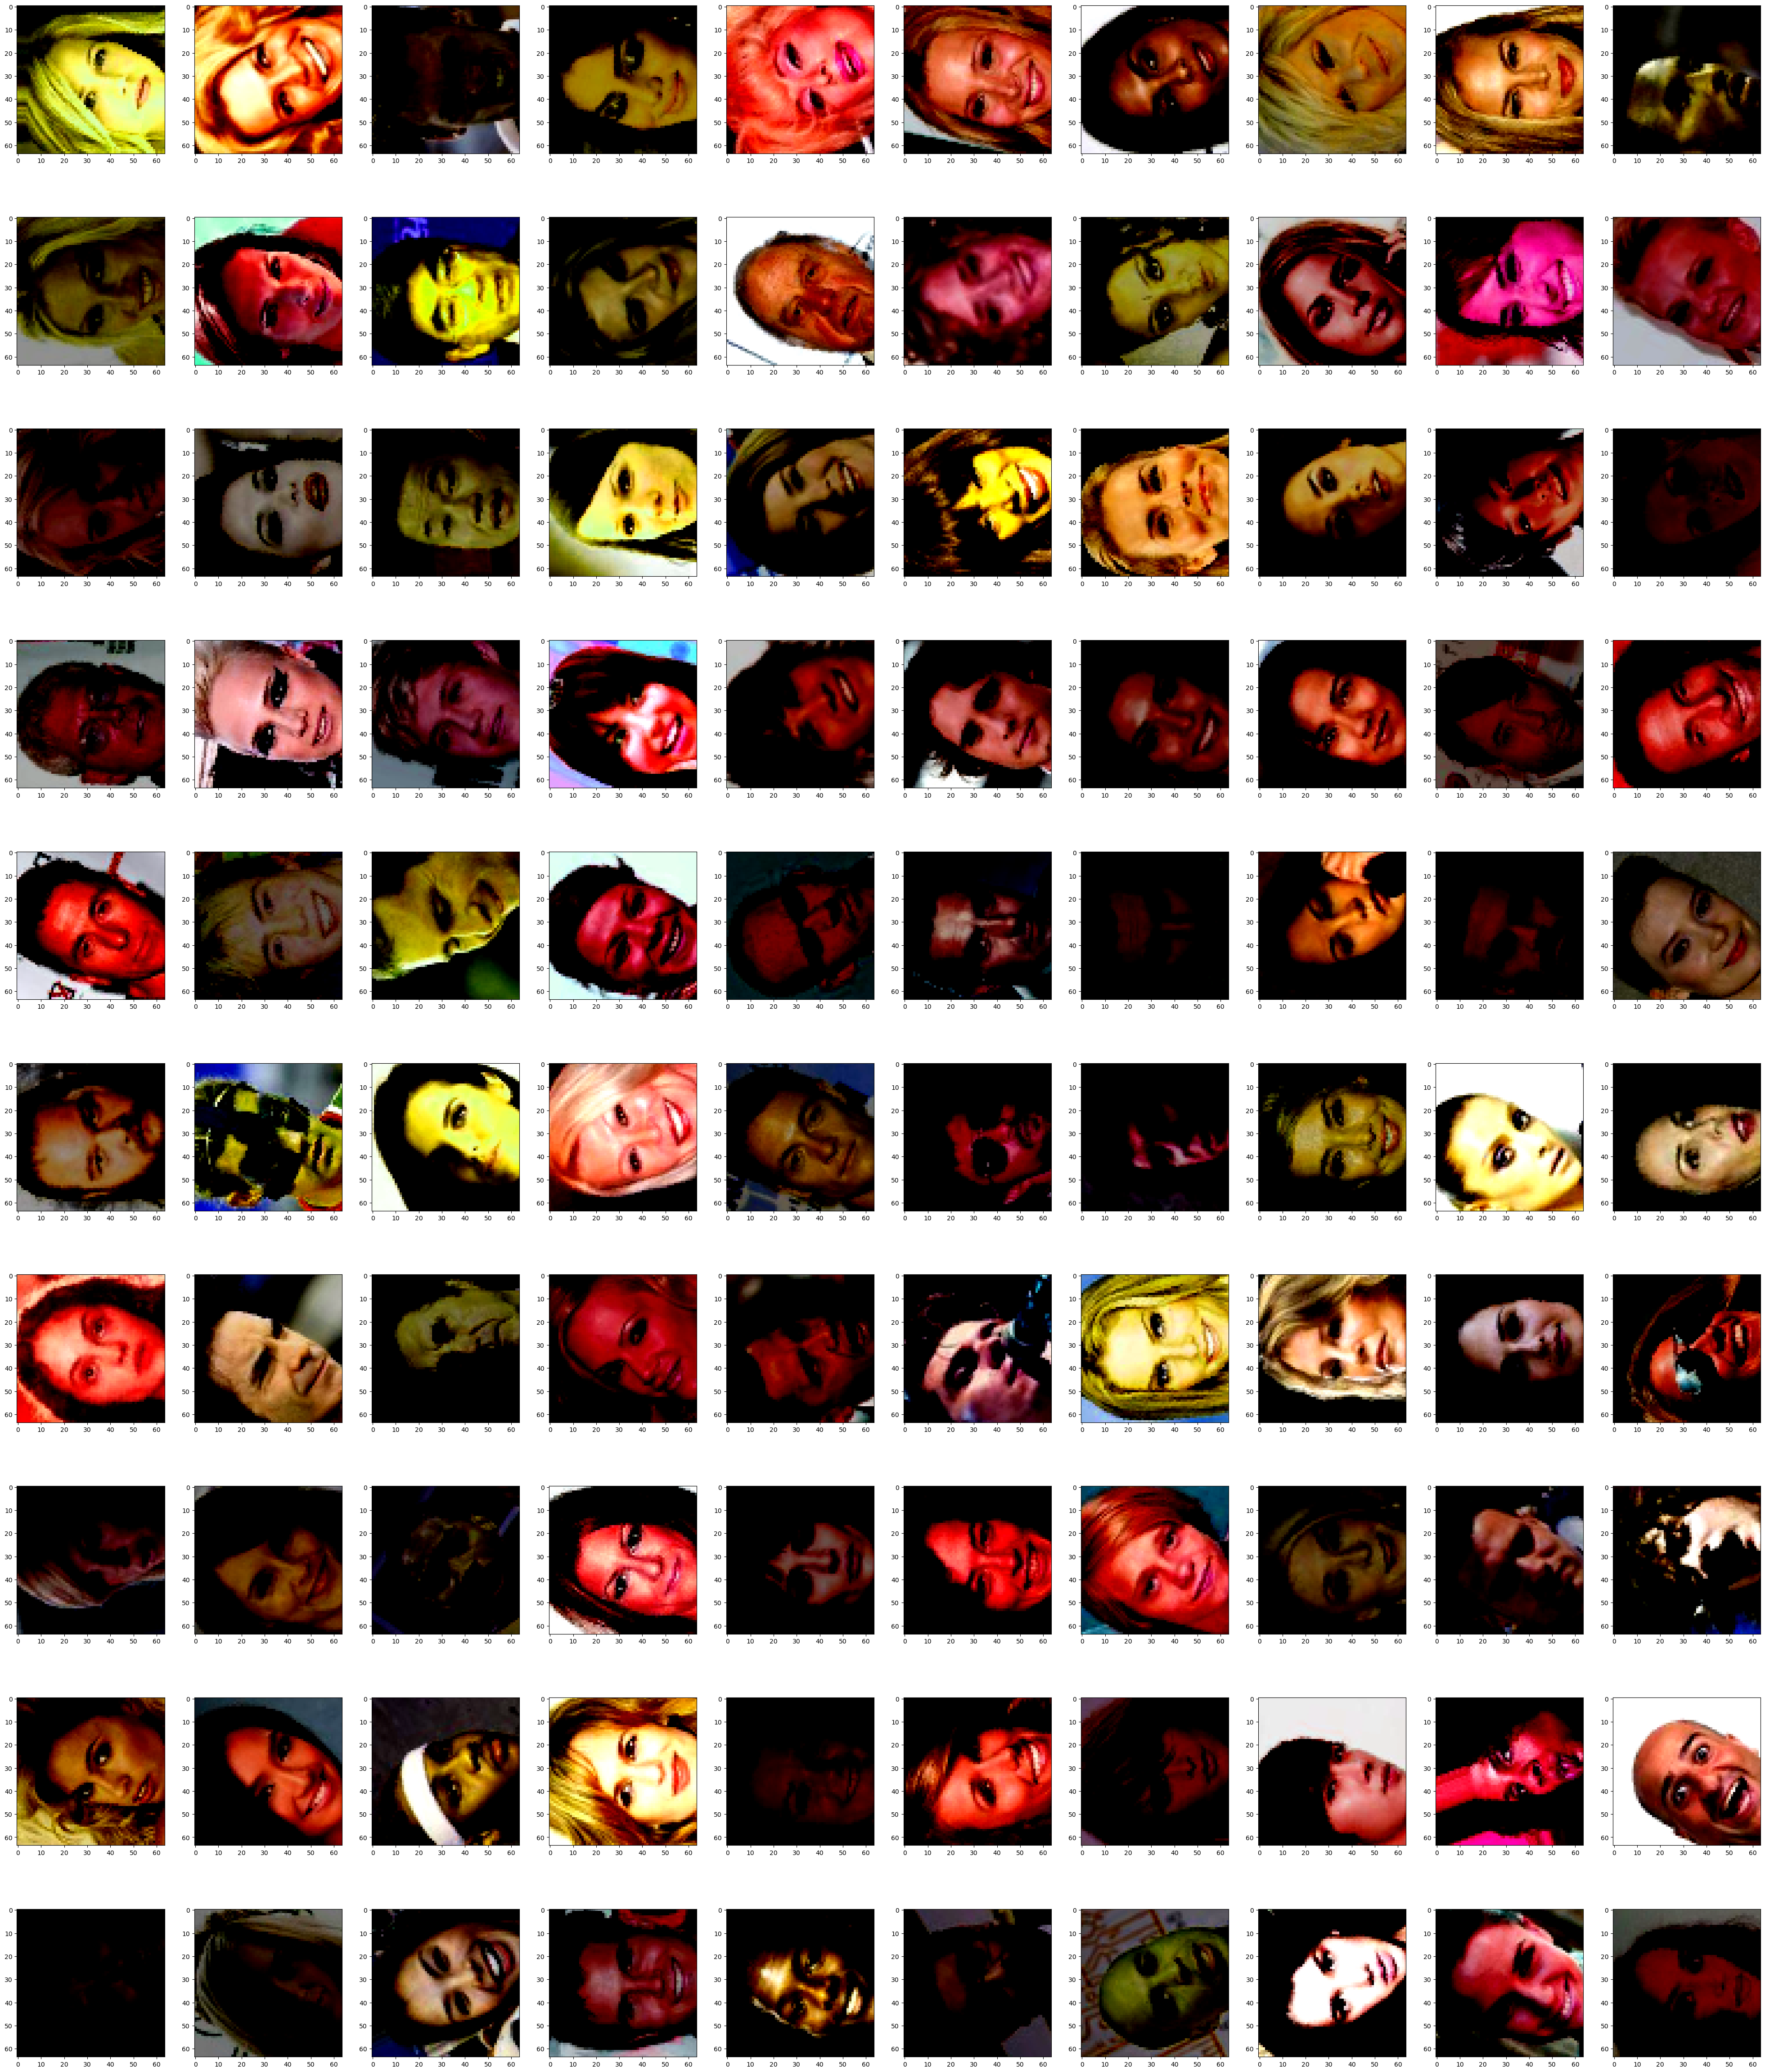

In [36]:
l = list(zip(a1[a2==0],a3[a2==0]))
l.sort(key=lambda x:x[1])
l = l[::-1]
fig, ax = plt.subplots(10,10,figsize=(50,60))

for i in range(10):
    for j in range(10):
        ax[i,j].imshow(l[i+j*10][0].numpy().T)
        ax[i,j].set_title(l[i+j*10][1].tolist())

In [37]:
next(iter(x))[1]

/home/michal/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[ 69, 112, 108,  ..., 153, 108, 151],
        [ 71, 109, 104,  ..., 153, 103, 156],
        [ 70, 111, 107,  ..., 154, 102, 152],
        ...,
        [ 68, 112, 109,  ..., 150, 108, 152],
        [ 71, 110, 106,  ..., 154, 102, 153],
        [ 70, 110, 106,  ..., 153, 104, 153]])

In [34]:
optimizer_discr = torch.optim.Adam(model.discriminator.parameters(),
                                       betas=(0.5, 0.999),
                                       lr=0.000001)
model2.to('cuda:0').type(torch.float)
pth = '/home/michal/data/data/celeba/test_celeba/img_align_celeba/'
train_smile_det(num_epochs = 10,l_ts=len(os.listdir(pth)), train_loader=x, test_loader=y, 
                labels=ff2, optimizer_discr=optimizer_discr, 
                batch_size=None,model=model2, device=['cuda:0','cuda:0'],
                logging_interval=100)

Epoch: 001/010 | Batch 000/009 | Train/Test Loss: 0.8155/0.8094
Epoch: 001/010 | Batch 100/009 | Train/Test Loss: 0.7957/0.7956
Epoch: 001/010 | Batch 200/009 | Train/Test Loss: 0.7802/0.7699
Epoch: 001/010 | Batch 300/009 | Train/Test Loss: 0.7687/0.7707
Epoch: 001/010 | Batch 400/009 | Train/Test Loss: 0.7591/0.7501
Epoch: 001/010 | Batch 500/009 | Train/Test Loss: 0.7395/0.7459


In [37]:
for i in model2.decoder.parameters():
    i.requires_grad = True

In [39]:
optimizer_discr = torch.optim.Adam(model.discriminator.parameters(),
                                       betas=(0.5, 0.999),
                                       lr=0.000001)
                                       
model2.to('cuda:0').type(torch.float)
pth = '/home/michal/data/data/celeba/test_celeba/img_align_celeba/'
train_smile_det(num_epochs = 1,l_ts=len(os.listdir(pth)), train_loader=x, test_loader=y, 
                labels=ff2, optimizer_discr=optimizer_discr, 
                batch_size=None,model=model2, device=['cuda:0','cuda:0'],
                logging_interval=100)

/home/michal/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 001/001 | Batch 000/009 | Train/Test Loss: 0.4694/0.4506
Epoch: 001/001 | Batch 100/009 | Train/Test Loss: 0.4539/0.4454
Epoch: 001/001 | Batch 200/009 | Train/Test Loss: 0.4600/0.4354
Epoch: 001/001 | Batch 300/009 | Train/Test Loss: 0.4423/0.4555
Epoch: 001/001 | Batch 400/009 | Train/Test Loss: 0.4593/0.4430
Epoch: 001/001 | Batch 500/009 | Train/Test Loss: 0.4408/0.4503
Epoch: 001/001 | Batch 600/009 | Train/Test Loss: 0.4583/0.4475
Epoch: 001/001 | Batch 700/009 | Train/Test Loss: 0.4381/0.4526
Epoch: 001/001 | Batch 800/009 | Train/Test Loss: 0.4407/0.4274
Epoch: 001/001 | Batch 900/009 | Train/Test Loss: 0.4313/0.4396
Epoch: 001/001 | Batch 1000/009 | Train/Test Loss: 0.4271/0.4635
Epoch: 001/001 | Batch 1100/009 | Train/Test Loss: 0.4354/0.4314
Epoch: 001/001 | Batch 1200/009 | Train/Test Loss: 0.4301/0.4357


In [47]:
a = torch.zeros(40)
with torch.no_grad():
    for n,(i,ygt) in enumerate(y):
        print(n)
        rypred = torch.round(model2.discriminator(i.to('cuda:0')))
        a += (rypred.to('cpu')*ygt+((-1)*rypred.to('cpu')+1)*((-1)*ygt+1)).sum(axis=0)
a/157/128

/home/michal/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


tensor([0.8941, 0.7015, 0.5639, 0.7892, 0.9723, 0.8388, 0.6665, 0.7766, 0.7201,
        0.8610, 0.9430, 0.8110, 0.8633, 0.9407, 0.9479, 0.9292, 0.9478, 0.9616,
        0.6114, 0.5358, 0.6146, 0.5087, 0.9549, 0.8455, 0.8417, 0.6736, 0.9515,
        0.6908, 0.9090, 0.9221, 0.9472, 0.5286, 0.7838, 0.6243, 0.7870, 0.9516,
        0.6015, 0.8561, 0.9233, 0.7494])

In [53]:
l = list(zip(f2.split('\n')[1].split(),a/128/156))
l.sort(key = lambda x:x[1])
l[::-1]

[('Bald', tensor(0.9785)),
 ('Gray_Hair', tensor(0.9678)),
 ('Mustache', tensor(0.9610)),
 ('Wearing_Hat', tensor(0.9577)),
 ('Pale_Skin', tensor(0.9576)),
 ('Double_Chin', tensor(0.9540)),
 ('Goatee', tensor(0.9539)),
 ('Sideburns', tensor(0.9533)),
 ('Blurry', tensor(0.9491)),
 ('Chubby', tensor(0.9467)),
 ('Eyeglasses', tensor(0.9351)),
 ('Wearing_Necktie', tensor(0.9292)),
 ('Rosy_Cheeks', tensor(0.9280)),
 ('Receding_Hairline', tensor(0.9149)),
 ('5_o_Clock_Shadow', tensor(0.8998)),
 ('Bushy_Eyebrows', tensor(0.8688)),
 ('Blond_Hair', tensor(0.8665)),
 ('Wearing_Necklace', tensor(0.8616)),
 ('Narrow_Eyes', tensor(0.8510)),
 ('No_Beard', tensor(0.8471)),
 ('Bangs', tensor(0.8442)),
 ('Brown_Hair', tensor(0.8162)),
 ('Bags_Under_Eyes', tensor(0.7943)),
 ('Wearing_Earrings', tensor(0.7921)),
 ('Straight_Hair', tensor(0.7889)),
 ('Big_Nose', tensor(0.7816)),
 ('Young', tensor(0.7542)),
 ('Black_Hair', tensor(0.7247)),
 ('Arched_Eyebrows', tensor(0.7060)),
 ('Pointy_Nose', tensor(0.695

In [54]:
a2 = torch.zeros(40)
with torch.no_grad():
    for n,(i,ygt) in enumerate(x):
        print(n)
        rypred = torch.round(model2.discriminator(i.to('cuda:0')))
        a2 += (rypred.to('cpu')*ygt+((-1)*rypred.to('cpu')+1)*((-1)*ygt+1)).sum(axis=0)

/home/michal/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [60]:
a2[31]/1271/128-a[31]/156/128

tensor(0.0070)

In [61]:
torch.save(model.state_dict(), './smile2.pt')

In [ ]:
optimizer_discr = torch.optim.Adam(model.discriminator.parameters(),
                                       betas=(0.5, 0.999),
                                       lr=0.000001)
                                       
model.to('cuda:0').type(torch.float)
pth = '/home/michal/data/data/celeba/test_celeba/img_align_celeba/'
train_smile_det(num_epochs = 1,l_ts=len(os.listdir(pth)), train_loader=x, test_loader=y, 
                labels=ff2, optimizer_discr=optimizer_discr, 
                batch_size=None,model=model, device=['cuda:0','cuda:0'],
                logging_interval=100)

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
Epoch: 001/001 | Batch 000/009 | Train/Test Loss: 0.5250/0.5174
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='

In [ ]:
yimg, ygt = next(iter(y))
ypred = model.discriminator(yimg.to('cuda:0'))
rypred = torch.round(ypred).detach().cpu()


In [ ]:
col = f2.split('\n')[1].split()

In [ ]:
acc = (rypred*ygt+((-1)*rypred+1)*((-1)*ygt+1)).sum(axis=0)/128

In [ ]:
l = list(zip(col,acc.tolist()))
l.sort(key = lambda x:x[1])
l[::-1]

[('Pale_Skin', 0.984375),
 ('Gray_Hair', 0.984375),
 ('Bald', 0.9765625),
 ('Blurry', 0.9609375),
 ('Wearing_Hat', 0.9453125),
 ('Sideburns', 0.9453125),
 ('Mustache', 0.9453125),
 ('Double_Chin', 0.9375),
 ('Eyeglasses', 0.9296875),
 ('Chubby', 0.9296875),
 ('Rosy_Cheeks', 0.9140625),
 ('Receding_Hairline', 0.90625),
 ('Bushy_Eyebrows', 0.90625),
 ('Narrow_Eyes', 0.8984375),
 ('Goatee', 0.890625),
 ('Wearing_Necktie', 0.875),
 ('Wearing_Necklace', 0.8671875),
 ('Bangs', 0.859375),
 ('5_o_Clock_Shadow', 0.859375),
 ('Wearing_Earrings', 0.84375),
 ('Blond_Hair', 0.8203125),
 ('Brown_Hair', 0.8125),
 ('Big_Nose', 0.796875),
 ('Bags_Under_Eyes', 0.796875),
 ('Black_Hair', 0.7890625),
 ('Straight_Hair', 0.7734375),
 ('No_Beard', 0.7734375),
 ('Wearing_Lipstick', 0.75),
 ('Arched_Eyebrows', 0.75),
 ('Young', 0.734375),
 ('Oval_Face', 0.7109375),
 ('Male', 0.703125),
 ('Big_Lips', 0.6953125),
 ('Pointy_Nose', 0.671875),
 ('Smiling', 0.65625),
 ('Heavy_Makeup', 0.6328125),
 ('Wavy_Hair', 0.57

In [ ]:
-1*(ypred-1).sum()+(ypred).sum()

tensor(5120., device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
((ypred.detach().cpu().numpy()>0).astype(np.int)*(ygt.numpy()>0).astype(np.int)).sum()

/tmp/ipykernel_302/3086487195.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ((ypred.detach().cpu().numpy()>0).astype(np.int)*(ygt.numpy()>0).astype(np.int)).sum()


1179